**Do Gould, Chapter 5, Problem 5.5**

This exam will be administered in class by Fred Bunt. He has a solution, and can answer basic questions.

Unless you've made special arrangements, you will have the entire period to complete it.

Instead of modifying  **Planet2**  you will modify your  **n_body.py**. Use your  **RK4**  to do the simulation. Find an appropriate time step.

Some hints follow:

-   The books equation 5.11 will be used to find the initial velocity.
-   As you code your function think carefully about the  _direction_ of the gravitational force and the _direction_ of the drag force. Refer back to your bullet work on drag forces.
-   To make the text more clear, the magnitude of the drag force is  Fd=0.1GMro2v2  where  r0  is the initial radius (the book doesn't say, but try 1-5 Earth radii and chose a value the shows what you want are trying to explain).
-   Equation 5.12 will give you the period (time) for 1 orbit. After 1 full orbit, 'turn on' the drag force in your RHS ODE function.
-   As the problem states, in these units the universal gravitational constant times the mass of Earth,  GM  = 20.  m  the mass of the satellite cancels out when determining acceleration for the ODE's right hand side.
-   Stop plotting the trajectory of the satellite, the energy, and the velocity if the satellite position is less than one Earth radius from the origin (crashed into the surface).

Submit an HTML output of the Jupyter notebook you develop. Place special emphasis on:

-   A plot of the trajectory of the satellite relative to Earth's radius (30 pts).
-   A plot of the total energy of the satellite (20 pts).
-   A plot of the velocity of the satellite (10 pts).
-   The Python function that encodes the right hand side (dy/dt) of the ODE (20 pts).
-   Answers to the questions in the book, which is a discussion of what you see in the plots (20 pts).

Open book, some web search, and definitely use previously written code.  **_No generative AI!_  _No use of repositories developed from this text!_**

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def n_body_with_drag(t, x, p):
    """
    ODE function for n-body problem with drag resistance

    Parameters:
    t (float): time
    x (np.array): state vector containing positions and velocities
    p (dict): parameters dictionary containing:
        - m (list): masses of particles
        - G (float): gravitational constant
        - dimension (int): number of spatial dimensions
        - drag_coeff (float): drag coefficient

    Returns:
    np.array: derivative of state vector (velocities and accelerations)
    """
    # Extract parameters
    masses = np.array(p['m'])
    G = p['G']
    dimensions = p['dimension']
    n_bodies = len(masses)
    drag_coeff = p.get('drag_coeff', 0)

    # Initialize derivative vector
    dxdt = np.zeros_like(x)

    # First half of dxdt is just the velocities from second half of x
    dxdt[:n_bodies*dimensions] = x[n_bodies*dimensions:]

    # Calculate gravitational forces
    force_matrices = np.zeros((dimensions, n_bodies, n_bodies))

    for i in range(n_bodies):
        for j in range(i+1, n_bodies):  # Only upper triangle
            # Calculate displacement vector between bodies i and j
            r_ij = []
            for d in range(dimensions):
                displacement = x[i*dimensions + d] - x[j*dimensions + d]
                r_ij.append(displacement)

            r_ij = np.array(r_ij)

            # Calculate distance
            r = np.sqrt(np.sum(r_ij**2))

            # Calculate gravitational force magnitude
            force_mag = -G * masses[i] * masses[j] / (r**3)

            # Calculate force components and fill force matrices
            for d in range(dimensions):
                force_matrices[d][i,j] = force_mag * r_ij[d]
                force_matrices[d][j,i] = -force_matrices[d][i,j]  # Fill in lower triangle

    # Calculate total forces and drag
    for i in range(n_bodies):
        for d in range(dimensions):
            total_grav_force = np.sum(force_matrices[d][i])

            # Apply drag only to the satellite (i > 0), not to Earth
            if i > 0:  # Only apply drag to satellite, not Earth
                # Get velocity for this dimension
                velocity = x[n_bodies*dimensions + i*dimensions + d]

                # Calculate drag force (proportional to velocity squared)
                # The negative sign ensures it opposes the direction of motion
                drag_force = -drag_coeff * velocity * np.abs(velocity)
            else:
                drag_force = 0

            # Total force (gravitational + drag)
            total_force = total_grav_force + drag_force

            # Calculate acceleration
            dxdt[n_bodies*dimensions + i*dimensions + d] = total_force / masses[i]

    return dxdt

In [14]:
# Earth-Satellite system in Earth units
G = 1.0  # Gravitational constant in Earth units
M_earth = 1.0  # Mass of Earth in Earth units
R_earth = 1.0  # Radius of Earth in Earth units
orbit_height = 0.1  # Satellite orbit height (10% of Earth radius)

# Calculate orbital velocity for circular orbit
orbit_radius = R_earth + orbit_height  # = 1.1 in Earth radius units
orbital_velocity = np.sqrt(G * M_earth / orbit_radius)

# Satellite mass as a tiny fraction of Earth's mass
satellite_mass = 1e-6  # One millionth of Earth's mass

Orbital radius: 1.1
Orbital velocity: 0.9534625892455924


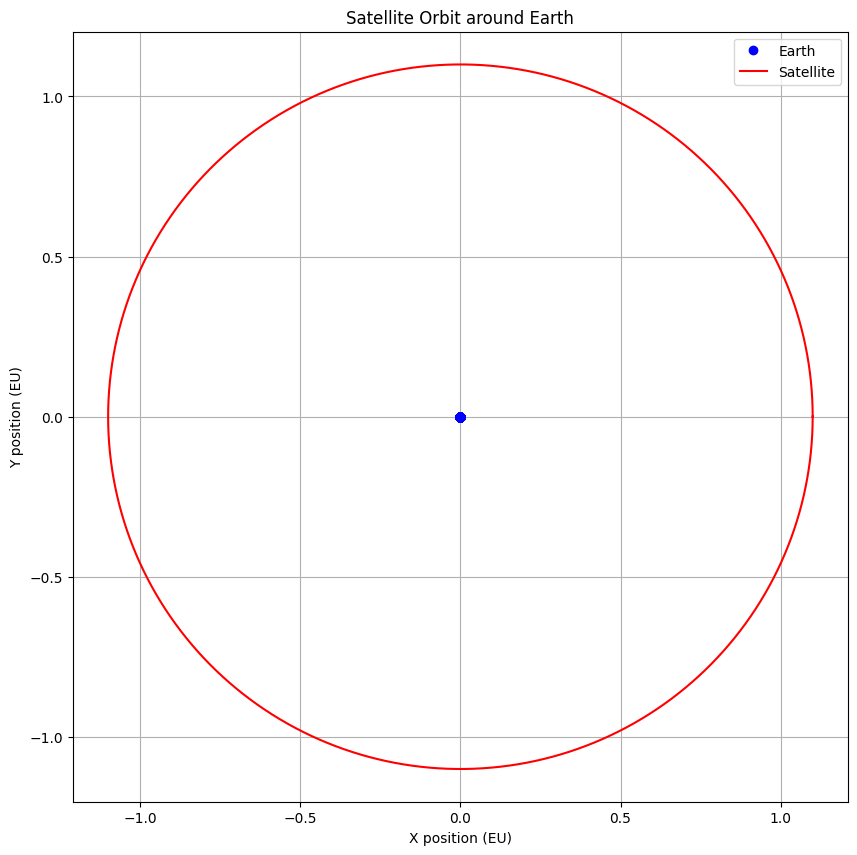

In [15]:
### NO DRAG ###

import numpy as np
import matplotlib.pyplot as plt
from ode_solver import *

# # Earth-Satellite system parameters
# # G = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
# G = 20
# M_earth = 5.99e24  # Mass of Earth (kg)
# R_earth = 6.371e6  # Radius of Earth (EU)
# orbit_height = 400e3  # Satellite orbit height above Earth's surface (EU)

# Initial conditions
# Earth at center (0,0)
# Satellite in circular orbit
earth_x = 0
earth_y = 0
earth_vx = 0
earth_vy = 0

# Calculate orbital velocity for circular orbit
orbit_radius = R_earth + orbit_height
orbital_velocity = np.sqrt(G * M_earth / orbit_radius)
print(f"Orbital radius: {orbit_radius}")
print(f"Orbital velocity: {orbital_velocity}")

satellite_x = orbit_radius
satellite_y = 0
satellite_vx = 0
satellite_vy = orbital_velocity

# Combine initial conditions
y0 = np.array([earth_x, earth_y, satellite_x, satellite_y,
               earth_vx, earth_vy, satellite_vx, satellite_vy])

# Parameters dictionary
p_no_drag = {
    'm': [M_earth, satellite_mass],  # Mass of Earth and satellite (kg)
    'G': G,
    'dimension': 2,
    'fix_first': True  # Fix Earth at origin
}

# Time span for simulation (one orbital period)
orbital_period = 2 * np.pi * np.sqrt(orbit_radius**3 / (G * M_earth))
t_span = [0, orbital_period]  # Run for one orbital period

# Solve ODE
t_no_drag, y_no_drag = solve_ode(n_body_with_drag, t_span, y0, RungeKutta, p_no_drag, first_step=0.001)

# Plot the orbit
plt.figure(figsize=(10, 10))
plt.plot(y_no_drag[:, 0], y_no_drag[:, 1], 'bo', label='Earth')  # Earth's trajectory
plt.plot(y_no_drag[:, 2], y_no_drag[:, 3], 'r', label='Satellite')  # Satellite's trajectory
plt.title('Satellite Orbit around Earth')
plt.xlabel('X position (EU)')
plt.ylabel('Y position (EU)')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

Note: Got a working satellite with no drag. Just gonna start another cell to make sure I don't screw something up.

Orbital radius: 1.1
Orbital velocity: 0.9534625892455924
[ 1.16792355e-14  6.91148310e-06  1.09999999e+00  1.67206003e-04
  1.38940753e-10  1.01233936e-14 -1.38940753e-04  9.53462579e-01]


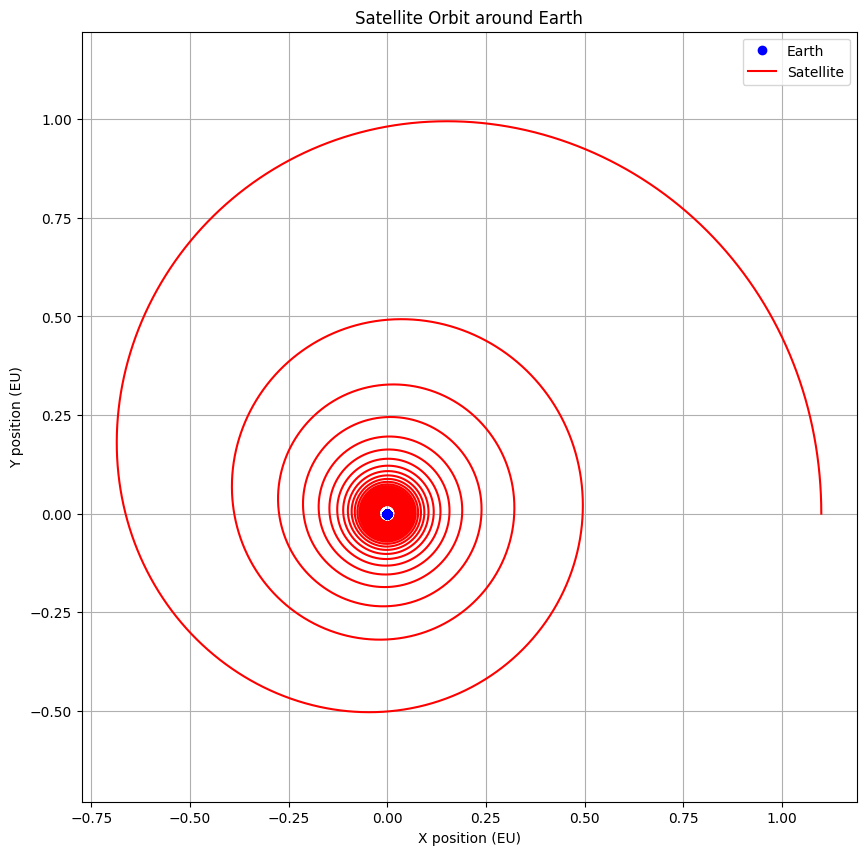

In [16]:
### WITH DRAG ###

import numpy as np
import matplotlib.pyplot as plt
from ode_solver import *

# Initial conditions
# Earth at center (0,0)
# Satellite in circular orbit
earth_x = 0
earth_y = 0
earth_vx = 0
earth_vy = 0

# Calculate orbital velocity for circular orbit
orbit_radius = R_earth + orbit_height
orbital_velocity = np.sqrt(G * M_earth / orbit_radius)
print(f"Orbital radius: {orbit_radius}")
print(f"Orbital velocity: {orbital_velocity}")

satellite_x = orbit_radius
satellite_y = 0
satellite_vx = 0
satellite_vy = orbital_velocity

# # Combine initial conditions
# y0 = np.array([earth_x, earth_y, satellite_x, satellite_y,
#                earth_vx, earth_vy, satellite_vx, satellite_vy])

# Continue from where the no-drag simulation left off
y0_drag = y_no_drag[-1]  # Take the last state from no-drag simulation
print(y0_drag)  # Starting conditions from the drag simulation where they left off in the no-drag simulation

# Time span for the drag simulation
t_span_drag = [t_no_drag[-1], t_no_drag[-1] + orbital_period * 1.5]  # Continue from where previous sim ended

# Parameters dictionary
p_with_drag = {
    'm': [M_earth, satellite_mass],  # Mass of Earth and satellite (kg)
    'G': G,
    'dimension': 2,
    'drag_coeff': 0.0000001,  # Drag coefficient # this works
    'fix_first': True  # Fix Earth at origin
}

# Solve ODE
t_drag, y_drag = solve_ode(n_body_with_drag, t_span_drag, y0_drag, RungeKutta, p_with_drag, first_step=0.001)

# Plot the orbit
plt.figure(figsize=(10, 10))
plt.plot(y_drag[:, 0], y_drag[:, 1], 'bo', label='Earth')  # Earth's trajectory
plt.plot(y_drag[:, 2], y_drag[:, 3], 'r', label='Satellite')  # Satellite's trajectory
plt.title('Satellite Orbit around Earth')
plt.xlabel('X position (EU)')
plt.ylabel('Y position (EU)')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

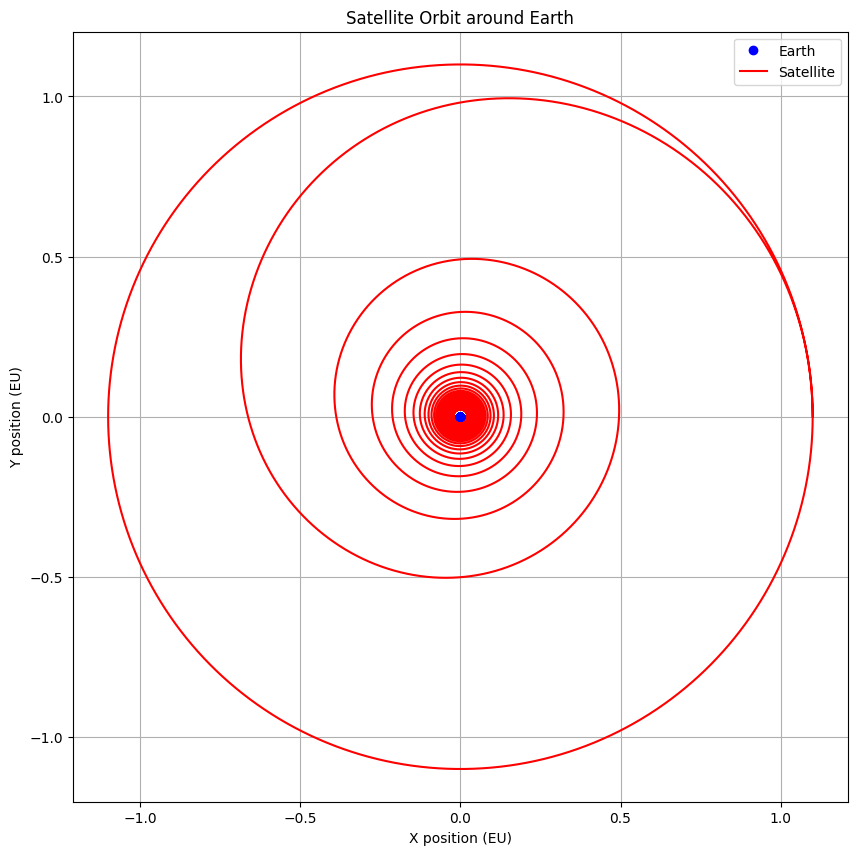

In [17]:
# Combine the results from the first orbit with no drag
# and vstack / concatenate the results from the second orbit with drag
t_total = np.concatenate((t_no_drag, t_drag))
y_total = np.concatenate((y_no_drag, y_drag))

# Plot the orbit -- *** THIS SHOULD PLOT ONE ORBIT WITH NO DRAG AND ONE ORBIT WITH DRAG ***
plt.figure(figsize=(10, 10))
plt.plot(y_total[:, 0], y_total[:, 1], 'bo', label='Earth')  # Earth's trajectory
plt.plot(y_total[:, 2], y_total[:, 3], 'r', label='Satellite')  # Satellite's trajectory
plt.title('Satellite Orbit around Earth')
plt.xlabel('X position (EU)')
plt.ylabel('Y position (EU)')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

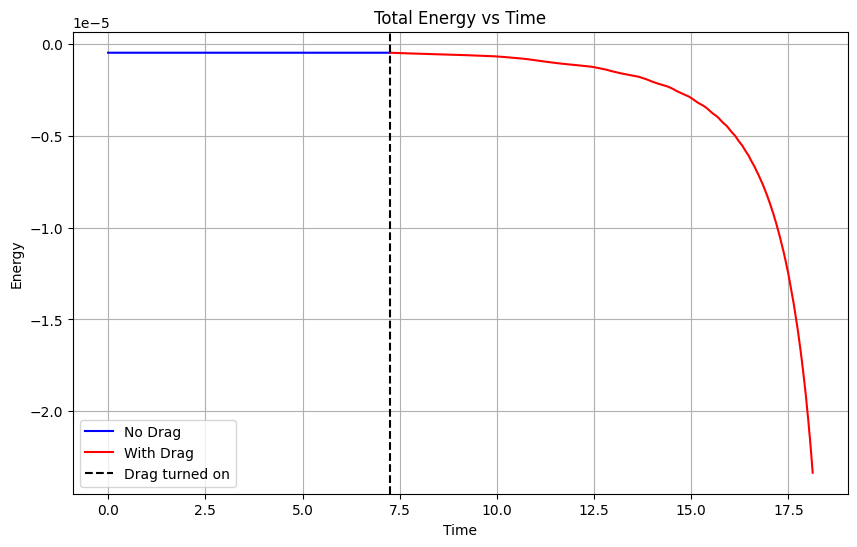

In [18]:
def calculate_energy(state_vector, p):
    # Extract positions and velocities for the satellite (second body)
    satellite_x = state_vector[2]
    satellite_y = state_vector[3]
    satellite_vx = state_vector[6]
    satellite_vy = state_vector[7]

    # Calculate radius (distance from Earth)
    r = np.sqrt(satellite_x**2 + satellite_y**2)

    # Calculate kinetic energy of satellite
    kinetic_energy = 0.5 * p['m'][1] * (satellite_vx**2 + satellite_vy**2)

    # Calculate potential energy between Earth and satellite
    potential_energy = -p['G'] * p['m'][0] * p['m'][1] / r

    # Total energy
    total_energy = kinetic_energy + potential_energy

    return total_energy

# Energy Plot
plt.figure(figsize=(10,6))

# Calculate energy for no-drag simulation
energy_no_drag = [calculate_energy(y, p_no_drag) for y in y_no_drag]

# Calculate energy for simulation with drag
energy_drag = [calculate_energy(y, p_with_drag) for y in y_drag]

# Create time arrays for the plots
times_no_drag = t_no_drag
times_drag = t_drag

# Plot energy vs time
plt.plot(times_no_drag, energy_no_drag, 'b-', label='No Drag')
plt.plot(times_drag, energy_drag, 'r-', label='With Drag')

# Add a vertical line to indicate where drag begins
plt.axvline(x=times_no_drag[-1], color='k', linestyle='--', label='Drag turned on')

plt.title('Total Energy vs Time')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)
plt.show()

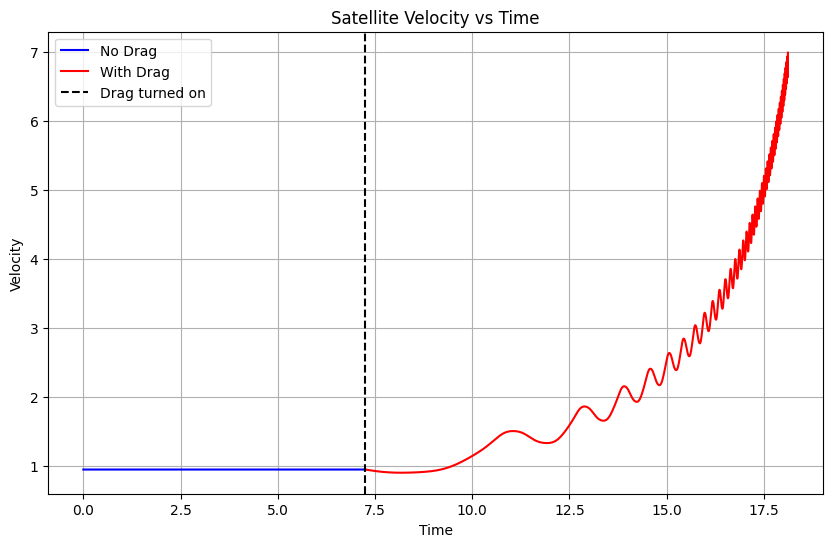

In [19]:
# Extract velocity components for the satellite (second body)
vx_no_drag = y_no_drag[:, 6]
vy_no_drag = y_no_drag[:, 7]
vx_drag = y_drag[:, 6]
vy_drag = y_drag[:, 7]

# Calculate the magnitude of the velocity
velocity_no_drag = np.sqrt(vx_no_drag**2 + vy_no_drag**2)
velocity_drag = np.sqrt(vx_drag**2 + vy_drag**2)

# Plot the velocity over time
plt.figure(figsize=(10, 6))
plt.plot(times_no_drag, velocity_no_drag, 'b-', label='No Drag')
plt.plot(times_drag, velocity_drag, 'r-', label='With Drag')

# Add a vertical line to indicate where drag begins
plt.axvline(x=times_no_drag[-1], color='k', linestyle='--', label='Drag turned on')

plt.title('Satellite Velocity vs Time')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()
plt.grid(True)
plt.show()

#### Discussion 


De-scribe the qualitative change of the orbit due to drag resistance. How does the total energy and the speed of the satellite change with time?

After the drag kicks in, the orbit should decay bringing the satelite closer to the planet until it potentially crashes into the planet. The total energy of the system should go down, and I think the speed would increase as it gets closer to the larger body